<img align="right" width="100" height="100" src="https://jatinangor.itb.ac.id/wp-content/uploads/sites/17/2012/12/Logo-ITB-polos20-1.jpg">

## Tugas Seismologi Komputasi 
*Meta Nisrina Syafitri - 22319302*<br>
*Farhan Hamid Lubis - 22319310*<br>
*Rizky Adityo Prastama - 22319310*
***
### Pembuatan seismogram sintetik

Siesmogram sintetik pada tugas ini didapat dari hasil perkalian konvolusi sebagai berikut:

\begin{align}
trace(t) = wavelet(t) \ast reflectivity(t)
\end{align}

Pembuatan seismogram sintetik ini terdiri dari beberapa tahapan antara lain:
- Pembuatan model kecepatan lapisan 2 dimensi 
- Konversi domain kedalaman menjadi domain waktu
- Resampling data
- Perhitungan koefisien refleksi
- Pembuatan wavelet sumber menggunakan model Ricker
- Konvolusi wavelet dengan koefisien refleksi
- Visualisasi 

Berikut ini dijelaskan tahapan dan fungsi yang digunakan dalam pembuatan seismogram sintetik

#### Step 1 : Pembuatan model kecepatan

Model kecepatan dibuat memiliki lima lapisan dengan dipping diposisikan pada kedalaman diatas 200 meter. Rata-rata lapisan memiliki ketebalan 200 meter dan memiliki lapisan tipis di kedalaman sekitar 380 - 480 meter. Model lapisan seperti ini bertujuan untuk melihat efek nilai frekuensi sumber terhadap resolusi vertikal dari seismogram sintetik yang dihasilkan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import interpolate
from ipywidgets import interact
%matplotlib inline

In [2]:
n_samples, n_traces = [600,300]
velocity = 1400*np.ones((n_samples, n_traces))

# Lapisan horizontal
velocity[200:300, :] = 2200
velocity[400:, :] = 3500

# Lapisan miring
x = np.arange(0,n_traces)
u1 = x/4
u1 = u1.astype(int)
for i in range(200,380):
    velocity[np.array(u1)+i, np.array(x)]=2600
for i in range(380,410):
    velocity[np.array(u1)+i, np.array(x)]=3000

Text(140, 520, '3500 m/s')

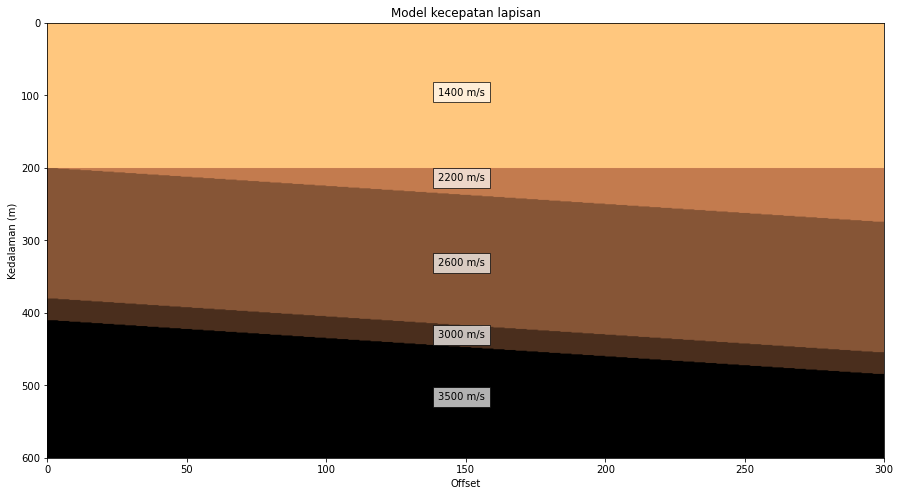

In [3]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Model kecepatan lapisan")
tmp = ax.imshow(velocity, extent=[0, n_traces, n_samples, 0],
                    cmap="copper_r", aspect='auto', origin='upper')
ax.set_xlabel('Offset')
ax.set_ylabel('Kedalaman (m)')
ax.text(140, 100, '1400 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
ax.text(140, 218, '2200 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
ax.text(140, 335, '2600 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
ax.text(140, 435, '3000 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
ax.text(140, 520, '3500 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

#### Step 2 : Konversi domain kedalaman ke dalam domain waktu

Tahapan ini bertujuan untuk menghasilkan model lapisan dalam domain waktu agar dapat dikonvolusi dengan wavelet sumber.

Parameter input:

    * vel : 2D-array
        Nilai kecepatan dalam domain kedalaman.
    * model : 2D-array
        Model kecepatan dalam domain kedalaman.
    * dt: float
        Nilai sampling rate wavelet sumber.
    * dz : float
        Panjang grid sel.
    * rho : 2D-array (optional)
        Nilai densitas model lapisan dalam domain kedalaman.
Return:

    * model_t : 2D-array
        Model lapisan dalam domain waktu.

In [4]:
def depth_2_time(vel, model, dt, dz):
    
    # downsampled time rate to make a better interpolation
    n_samples, n_traces = [vel.shape[0], vel.shape[1]]
    dt_dwn = dt/10.

    if dt_dwn > dz/np.max(vel):
        dt_dwn = (dz/np.max(vel))/10.

    TWT = np.zeros((n_samples, n_traces))
    TWT[0, :] = 2*dz/vel[0, :]

    for j in range(1, n_samples):
        TWT[j, :] = TWT[j-1]+2*dz/vel[j, :]
        TMAX = max(TWT[-1, :])
        TMIN = min(TWT[0, :])
        TWT_rs = np.zeros(int(np.ceil(TMAX/dt_dwn)))

    for j in range(1, len(TWT_rs)):
        TWT_rs[j] = TWT_rs[j-1]+dt_dwn

    resmpl = int(dt/dt_dwn)
    model_t = _resampling(model, TMAX, TWT, TWT_rs, dt, dt_dwn, n_traces)
    
    return model_t

#### Step 3 : Resampling data

Proses ini bertujuan untuk menyesuaikan model kecepatan domain waktu dengan nilai nilai sampling rate (dt) yang telah ditentukan

Return:

    * vel_l : 2D-array
        Inputan data hasil sampling ulang.

In [5]:
def _resampling(model, TMAX, TWT, TWT_rs, dt, dt_dwn, n_traces):
    
    vel = np.ones((int(np.ceil(TMAX/dt_dwn)), n_traces))
    for j in range(0, n_traces):
        kk = int(np.ceil(TWT[0, j]/dt_dwn))
        lim = int(np.ceil(TWT[-1, j]/dt_dwn)-1)
        
    # necessary do before resampling to have values in all points of time model
        tck = interpolate.interp1d(TWT[:, j], model[:, j])
        vel[kk:lim, j] = tck(TWT_rs[kk:lim])
        
    # the model is extended in time because of depth time conversion
        vel[lim:, j] = vel[lim-1, j]
        
    # because of time conversion, the values between 0 e kk need to be filed
        vel[0:kk, j] = model[0, j]
        
    # resampling from dt_dwn to dt
    vel_l = np.zeros((int(np.ceil(TMAX/dt)), n_traces))
    resmpl = int(dt/dt_dwn)
    vel_l[0, :] = vel[0, :]
    for j in range(0, n_traces):
        for jj in range(1, int(np.ceil(TMAX/dt))):
            vel_l[jj, j] = vel[resmpl*jj, j]
            
    return vel_l

#### Step 4 : Perhitungan koefisien refleksi

Perhitungan nilai koefisien refleksi pada tahapan ini dilakukan dalam domain waktu, sehingga model kecepatan perlu dikonversikan terlebih dahulu ke dalam domain waktu. Nilai koefisien refleksi dihitung menggunakan persamaan sebagai berikut

$$ RC = \frac{\rho_2 V_2 - \rho_1V_1}{\rho_2 V_2 + \rho_1V_1} $$

Parameter input:

    * model_t : 2D-array
        Nilai kecepatan dalam domain waktu.
    * rho : 2D-array (optional)
        Nilai densitas dalam domain waktu.

Return:

    * rc : 2D-array
        Nilai koefisien refleksi untuk masing-masing lapisan.


In [6]:
def reflectivity(model_t, rho):
    
    rc = np.zeros(np.shape(model_t))
    rc[1:, :] = ((model_t[1:]*rho[1:]-model_t[:-1]*rho[:-1]) /
                 (model_t[1:]*rho[1:]+model_t[:-1]*rho[:-1]))
    return rc

#### Step 5 : Pembuatan wavelet sumber - model Ricker

Pembuatan wavelet sumber menggunakan model Ricker dihitung dengan menggunakan persamaan berikut:

$$
f(t)=(1-2\pi^2f_m^2t^2)e^{-\pi^2f^2_Mt^2}
$$

Agar stabilitas dapat tercapai, penentuan nilai frekuensi perlu memenuhi syarat berikut: 

$$
    f << \frac{1}{2 dt}.
$$

Parameter input:

    * f : float
        Nilai frekuensi dominan (Hz)
    * dt : float
        Nilai sampling rate wavelet sumber (ms).

Return:

    * ricker : float
        Fungsi wavelet Ricker.

In [7]:
def ricker(f,dt,length):
    t=np.linspace(-length/2,(length)/2,int((length+dt)/dt))
    y=(1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t,y

#### Step 6 : Perhitungan konvolusi

Pada tahapan ini dilakukan konvolusi pada model kecepatan lapisan. Nilai densitas lapisan besifat opsional dan dapat ditambahkan.  

Parameter input:

    * rc : 2D-array
        Nilai koefisien refleksi dalam domain waktu.
    * f : float
        Nilai frekuensi dominan wavelet sumber.
    * wavelet : float
        Fungsi wavelet sumber yang digunakan.
    * dt: float
        Nilai sampling rate wavelet sumber.

Return:

    * synth_l : 2D-array
        Hasil seismogram sintetik.

In [8]:
def convolutional_model(rc, f, wavelet, dt):

    t,w = wavelet(f, dt, length)
    synth_l = np.zeros(np.shape(rc))
    for j in range(0, rc.shape[1]):
        if np.shape(rc)[0] >= len(w):
            synth_l[:, j] = np.convolve(rc[:, j], w, mode='same')
        else:
            aux = np.floor(len(w)/2.)
            synth_l[:, j] = np.convolve(rc[:, j], w, mode='full')[aux:-aux]
    return synth_l

#### Step 7 : Visualisasi
    
Parameters:

    * section :  2D array
        Tras seismik dalam bentuk matriks.
    * dt : float
        Nilai sampling rate.
    * ranges : (x1, x2)
        Jarak minimal dan maksimal tras (menentukan jumlah tras).
    * scale : float
        Faktor skala untuk dikalikan pada amplitude seismik.
    * color : tuple atau strings
        Warna pada wiggle seismik.
    * normalize :
        Normalisasi tras menggunakan nilai max/min global (True/False)

In [9]:
def seismic_wiggle(section, dt=0.002, ranges=None, scale=1.,
                   color='k', normalize=True):
    
    npts, ntraces = section.shape  # time/traces
    if ntraces < 1:
        raise IndexError("Nothing to plot")
    if npts < 1:
        raise IndexError("Nothing to plot")
    t = np.linspace(0, dt*npts, npts)
    amp = 1.  # normalization factor
    gmin = 0.  # global minimum
    toffset = 0.  # offset in time to make 0 centered
    
    if normalize:
        gmax = section.max()
        gmin = section.min()
        amp = (gmax-gmin)
        toffset = 0.5
    plt.ylim(max(t), 0)
    
    if ranges is None:
        ranges = (0, ntraces)
    x0, x1 = ranges
    
    # horizontal increment
    dx = float((x1-x0)/ntraces)
    plt.xlim(x0, x1)
    
    for i, trace in enumerate(section.transpose()):
        tr = (((trace-gmin)/amp)-toffset)*scale*dx
        x = x0+i*dx  # x positon for this trace
        plt.plot(x+tr, t, 'k')
        plt.fill_betweenx(t, x+tr, x, tr > 0, color=color)

In [10]:
# Konvolusi
dt = 1e-3
length = 0.2
vel_l = depth_2_time(velocity, velocity, dt, dz=1)
rho_l = 2200*np.ones(np.shape(vel_l))
rc = reflectivity(vel_l, rho_l)

def visualise(f):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    
    ax = axes[0]
    ax.set_title("Velocity model (in depth)")
    tmp = ax.imshow(velocity, extent=[0, n_traces, n_samples, 0],
                    cmap="copper_r", aspect='auto', origin='upper')
    ax.set_xlabel('Offset')
    ax.set_ylabel('Depth (m)')
    ax.text(125, 100, '1400 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
    ax.text(125, 218, '2200 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
    ax.text(125, 335, '2600 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
    ax.text(125, 435, '3000 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
    ax.text(125, 520, '3500 m/s',bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

    ax = axes[1]
    ax.set_title("Wavelet (Ricker)")
    [t,y]=ricker(f,dt,length)
    ax.plot(y,t)
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Time (s)')
    ax.invert_yaxis()

    ax = axes[2]
    ax.set_title("Synthetic seismogram")
    synt = convolutional_model(rc, f, ricker, dt)
    seismic_wiggle(synt[:, ::20], dt, scale=1.5)
    ax.set_xlabel('Trace')
    ax.set_ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

style = {'description_width': 'initial'}
layout = {'width': '400px'}

interact(visualise,f = widgets.IntSlider(min=5, 
                                         max=50, 
                                         step=5, 
                                         value=15,
                                         description = 'Frekuensi dominan',
                                         layout = layout, 
                                         style=style))


interactive(children=(IntSlider(value=15, description='Frekuensi dominan', layout=Layout(width='400px'), max=5…

<function __main__.visualise(f)>

***
### Reference

Yilmaz, Oz,
Ch.2 Deconvolution. In: YILMAZ, Oz. Seismic Data Analysis: Processing,
Inversion, and Interpretation of Seismic Data. Tulsa: Seg, 2001. Cap. 2.
p. 159-270. Available at: <http://dx.doi.org/10.1190/1.9781560801580.ch2>